## PAM50 processing

This is a Jupyter notebook.

To run all cells in the notebook use `Cell --> Run All`.

To run cells one at a time click into the first code cell and key `Shift-Enter` in each cell in sequence.

More information on Jupyter notebooks can be found
[here](http://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Running%20Code.html).

In [1]:
## Set the plot window sizes within the notebook (in inches)
options(repr.plot.width=6, repr.plot.height=8)

In [2]:
## User-provided data
fn.hist  <- './user_data/UserDogData_Phenotype.csv' # User-provided
fn.dd    <- './user_data/UserDogData_RNASeq.tab'    # Dog RNASeq expression data filename
fn.sep   <- '\t'     # delimiter for dog data files

## FREYA-provided data
data.dir        <- './data/' # Working directory for provided data
fn.brca         <- paste0(data.dir,'BRCA_rnaseq_paired_noMets.t.txt')
fn.pam50.genes  <- paste0(data.dir,'PAM50_genes.csv') 
fn.brca.pam50   <- paste0(data.dir,'BRCA_PAM50_labels.csv')

## PEP lists created in the expression pipeline. This is also Supp Table 1 in the manuscript
#  Users can either use the provided PEP lists or generate their own using the PEP generation script/notebook.
fn.peps  <- './data/CMT_peps.csv'  

In [3]:
## uncomment the following lines to use synthetic (fake) data to test the workflow
 fn.hist <- './synthetic_data/User_SampleData_Phenotype.csv'
 fn.dd <- './synthetic_data/User_SampleData_RNAseq.tab'

In [4]:
## Make sure all of the required files exist - quit if any are missing
for( fn in c(fn.hist, fn.dd, fn.peps, fn.pam50.genes, fn.brca, fn.brca.pam50) ) {
  if(!file.exists(fn)) { print(paste('ERROR: Unable to locate',fn)) }
}

In [5]:
## Create an output directory for artifacts (if it doesn't already exists)
output.dir <- './user_data/output'
system(paste('mkdir -p', output.dir))

## output filenames
output.pam50.barplots               <- paste(output.dir,'PAM50_barplots.pdf', sep='/')
PAM50.combined.heatmap.subtypes.bar <- paste(output.dir,'PAM50_combined_heatmap_subtypes_bar.pdf', sep='/')
PAM50.combined.species.bar          <- paste(output.dir,'PAM50_combined_species_bar.pdf', sep='/')
pam50.file                          <- paste(output.dir,'PAM50_dog.csv', sep='/')

In [6]:
## Load libraries
source("https://bioconductor.org/biocLite.R")
biocLite()
library(sva)
library(glmnet)
library(gplots)

Bioconductor version 3.6 (BiocInstaller 1.28.0), ?biocLite for help
BioC_mirror: https://bioconductor.org
Using Bioconductor 3.6 (BiocInstaller 1.28.0), R 3.4.2 (2017-09-28).
Old packages: 'backports', 'BH', 'bindr', 'bindrcpp', 'blob', 'broom', 'callr',
  'cluster', 'curl', 'DBI', 'dbplyr', 'devtools', 'digest', 'forcats',
  'foreach', 'gdtools', 'git2r', 'glmnet', 'haven', 'hexbin', 'Hmisc', 'hms',
  'htmlTable', 'htmlwidgets', 'httpuv', 'hunspell', 'igraph', 'irlba',
  'iterators', 'knitr', 'littler', 'lubridate', 'mapproj', 'maps', 'MASS',
  'Matrix', 'mgcv', 'microbenchmark', 'mvtnorm', 'nlme', 'openssl', 'pbdZMQ',
  'plogr', 'psych', 'quantreg', 'Rcpp', 'remotes', 'reprex', 'reshape2',
  'rlang', 'rmarkdown', 'RMySQL', 'rpart', 'rprojroot', 'RSQLite', 'selectr',
  'sp', 'stringdist', 'stringi', 'stringr', 'testthat', 'tibble', 'tidyr',
  'tidyselect', 'viridis', 'viridisLite', 'withr', 'XML', 'xml2', 'yaml', 'zoo'
Loading required package: mgcv
Loading required package: nlme
This

In [7]:
## PAM50 genes list - this never changes
genes <- rownames(read.table(fn.pam50.genes, sep=',', row.names=1))

In [8]:
## Load the PEPs
peps <- read.table(fn.peps, sep=',', header=TRUE, stringsAsFactors=FALSE)

## Convert to PEP lists
peps <- list( Adenoma=peps[peps$Adenoma_Expression_Pattern < 0.05,'HumanSymbol'], 
             Carcinoma=peps[peps$Carcinoma_Expression_Pattern < 0.05,'HumanSymbol'], 
             Tumor=peps[peps$Tumor_Expression_Pattern < 0.05,'HumanSymbol'])

# Print the number of genes in each PEP 
print(sapply(peps, length))

  Adenoma Carcinoma     Tumor 
      167       270       901 


In [9]:
## Load the human data
dat <- read.table(fn.brca, sep='\t', header=T, row.names=1, check.names=F)
dat <- dat[,genes] # Subset to PAM50 genes
dat <- log(dat+0.01, base=2) # Log scale

## Create the Tumor/Normal labels
dat.status    <- substr(rownames(dat),14,15) # Tumor/Normal labels

## Remove 'A' from the labels, to match other human data labels
rownames(dat) <- substr(rownames(dat),1,15) # Remove the 'A' from labels

In [10]:
# Load the pam50 labels
pam50.labs <- read.table(fn.brca.pam50, sep=',', header=TRUE, row.names=1, check.names=FALSE)

## Subset expression & labels data to overlapping sets
ids        <- intersect( rownames(dat), rownames(pam50.labs) )
dat        <- dat[ids,]
pam50.labs <- pam50.labs[ids,,drop=FALSE]

In [11]:
## Remove NA subtypes
if( any(is.na(pam50.labs)) ) {
  ids.na     <- rownames(pam50.labs)[which(!is.na(pam50.labs))] # Names for non-NA labels
  dat        <- dat[ids.na,]
  pam50.labs <- pam50.labs[ids.na,,drop=FALSE]
}

In [12]:
## Load the canine data 
dat.dog <- read.table(fn.dd, header=TRUE, row.names=1, check.names=FALSE, sep=fn.sep)

In [13]:
## Drop human & dog data matrices to the overlapping genes
genes     <- genes[genes %in% colnames(dat.dog)]
dat.dog   <- dat.dog[,genes]
dat.pam50 <- dat[,genes]

In [14]:
## Load the phenotype data for the dogs
dog.clin <- read.table(fn.hist, sep=',', header=T, row.names=1)

In [15]:
## Subset dog expression & phenotype data to overlapping samples
ids <- intersect( rownames(dog.clin), rownames(dat.dog) )
if(  !all(rownames(dog.clin) %in% ids & rownames(dat.dog) %in% ids) ) { 
  print("WARNING: Dog expression and phenotype data have unmatched samples!");
  dat.dog  <- dat.dog[ids,]
  dog.clin <- dog.clin[ids,]
}

In [16]:
## Color palettes for the manuscript
cols.palette <- c('#9DC7D8','#7FA1BE','#EBDA8C','#01B3CA','#4F6E35','#965354','#7DD1B9','#808040','#C6CBCE','#1D4E88','#C78C6C','#F69256','#D2B29E','#8B868C','#E38691','#B490B2')
cols.hist    <- c('#7DD1B9','#EBDA8C','#965354') # order = healthy, benign, malignant
cols.peps    <- c('#7FA1BE','#F69256','#E38691') # order = tumor, adenoma, carcinoma
cols         <- cols.palette[! (cols.palette %in% c(cols.hist, cols.peps)) ] # Don't resue the pep/histology colors

In [17]:
## Prepare combined human & dog data to remove batch effects
dat.both     <- rbind( dat.dog, dat.pam50 )
pheno        <- as.factor(c( rep('Dog', nrow(dat.dog)), rep('Human', nrow(dat.pam50)) ) )
names(pheno) <- c(rownames(dat.dog), rownames(dat.pam50))

In [18]:
## Run ComBat on combined human and dog data
combat.edata <- t(ComBat(dat=t(dat.both), batch=pheno))

## Mean center the data
combat.edata <- sweep(combat.edata, 1, rowMeans(combat.edata))

Found2batches
Adjusting for0covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data



In [19]:
#########################################
## Train PAM50 model & predict subtypes for dog
#####################################

## Irain subtype predictor, then predict dog samples
res             <- cv.glmnet(combat.edata[rownames(pam50.labs),], pam50.labs[,1], family='multinomial')
preds           <- predict(res, combat.edata, type='class')
rownames(preds) <- rownames(combat.edata)

Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”Warning message in lognet(x, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”

In [20]:
## Write predictions to file (dog only)
write.table( preds[rownames(dat.dog),,drop=FALSE], sep=',', col.names=FALSE, row.names=TRUE, quote=FALSE, file=pam50.file)

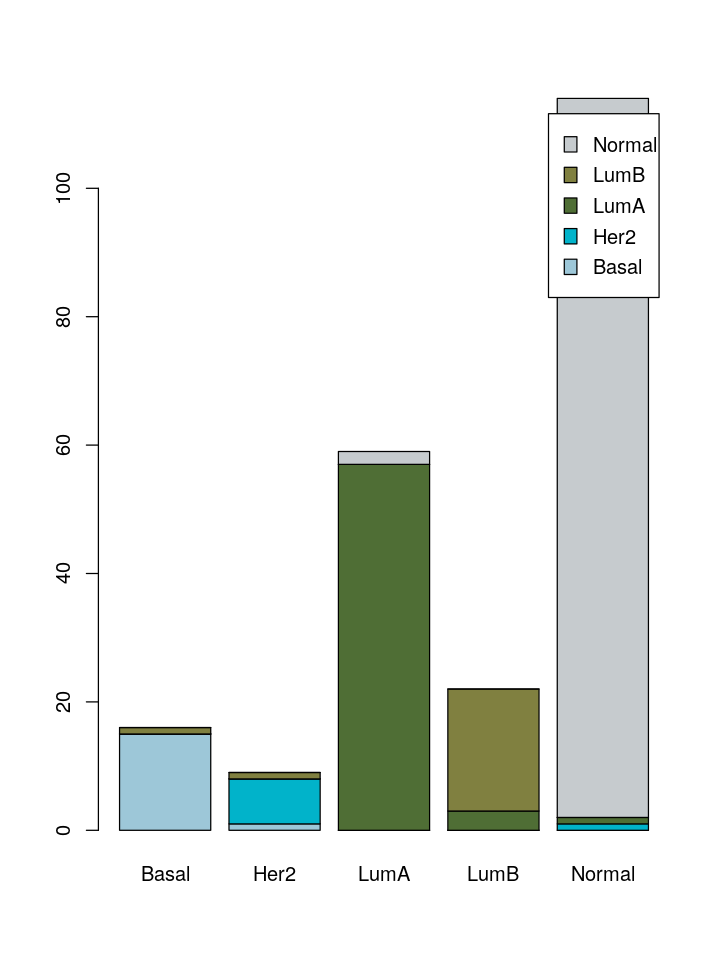

png 
  2

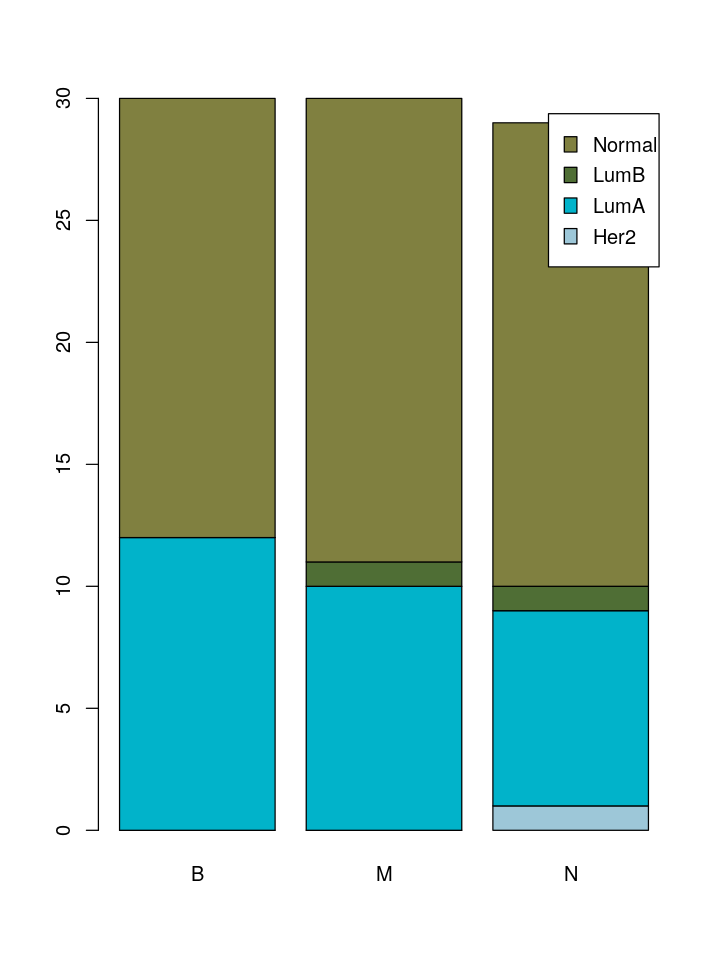

In [21]:
## Barplots of the predictions - not used in manuscript
barplot(table(preds[rownames(pam50.labs),1], pam50.labs[,1]), legend=TRUE, col=cols) # Human sample predictions
barplot( table(preds[rownames(combat.edata) %in% rownames(dog.clin),1], dog.clin$Hist ), legend=TRUE, col=cols ) # Dog sample predictions

## Save barplots to file
pdf(output.pam50.barplots)
barplot(table(preds[rownames(pam50.labs),1], pam50.labs[,1]), legend=TRUE, col=cols) # Human sample predictions
barplot( table(preds[rownames(combat.edata) %in% rownames(dog.clin),1], dog.clin$Hist ), legend=TRUE, col=cols ) # Dog sample predictions
dev.off()

In [22]:
#########################################
## Combined (human & dog) heatmaps showing PAM50 subtypes
#####################################

## Identify PAM50 Genes in the PEP lists
genes.cols <- rep('grey60', ncol(combat.edata))
names(genes.cols) <- colnames(combat.edata)
genes.cols[intersect(names(genes.cols), peps$Tumor)]     <- cols.peps[1] # Tumor PEP genes
genes.cols[intersect(names(genes.cols), peps$Adenoma)]   <- cols.peps[2] # Adenoma PEP genes
genes.cols[intersect(names(genes.cols), peps$Carcinoma)] <- cols.peps[3] # Carcinoma PEP genes

In [23]:
## Colors for the PAM50 subtypes
preds.cols <- matrix(nrow=nrow(preds),ncol=ncol(preds)+1, dimnames=list(rownames(preds)))
preds.cols[preds[,1]=='Normal',1] <- cols.palette[4]
preds.cols[preds[,1]=='Her2',1]   <- cols.palette[13]
preds.cols[preds[,1]=='LumA',1]   <- cols.palette[1]
preds.cols[preds[,1]=='LumB',1]   <- cols.palette[10]
preds.cols[preds[,1]=='Basal',1]  <- cols.palette[9]

## Color bar for the species
preds.cols[names(pheno),2]        <- pheno
preds.cols[preds.cols[,2]=='1',2] <- cols.palette[10] # Purple
preds.cols[preds.cols[,2]=='2',2] <- cols.palette[3] # Dark green

png 
  2

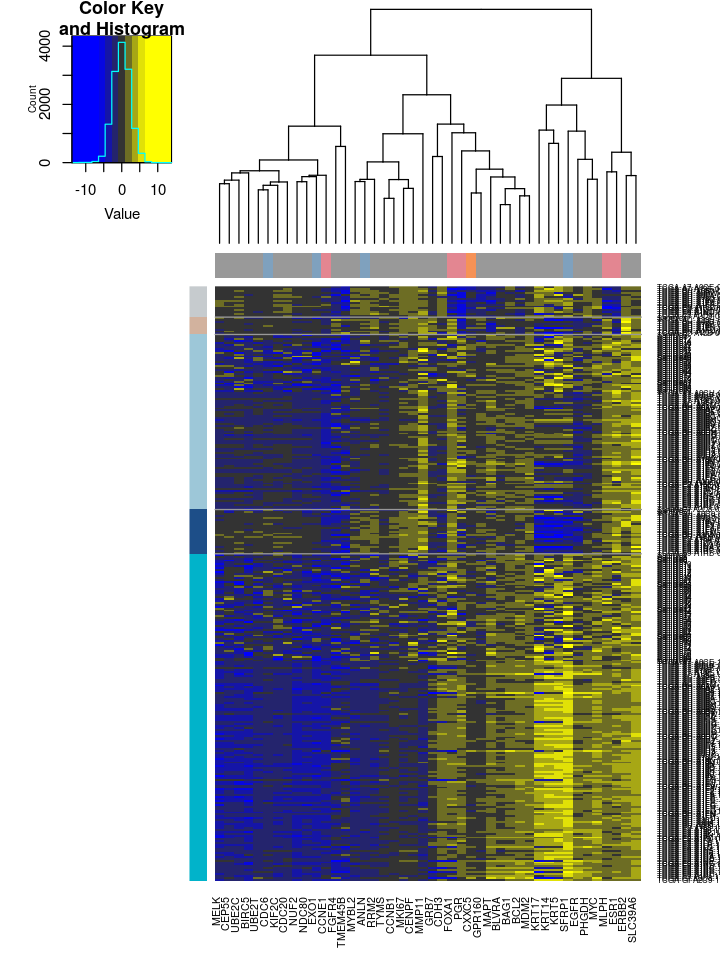

In [24]:
## Add line breaks for each PAM50 subtype gorup in the heatmaps
tbl.preds <- table(preds)
rowsep.nums <- c( sum(tbl.preds[1]), sum(tbl.preds[1:2]), sum(tbl.preds[1:3]), sum(tbl.preds[1:4]) )

## Heatmap with PAM50 Subtype color bar
heatmap.2(combat.edata[names(sort(preds[,1])),], trace='none', col=colorRampPalette(c('blue','blue','grey20','yellow','yellow')), RowSideColors=preds.cols[names(sort(preds[,1])),1], dendrogram='column', ColSideColors=genes.cols, Rowv='none', rowsep=rowsep.nums, sepcolor='grey60')
pdf(PAM50.combined.heatmap.subtypes.bar,width=8,height=20) 
heatmap.2(combat.edata[names(sort(preds[,1])),], trace='none', col=colorRampPalette(c('blue','blue','grey20','yellow','yellow')), RowSideColors=preds.cols[names(sort(preds[,1])),1], dendrogram='column', ColSideColors=genes.cols, Rowv='none', rowsep=rowsep.nums, sepcolor='grey60')
dev.off()

png 
  2

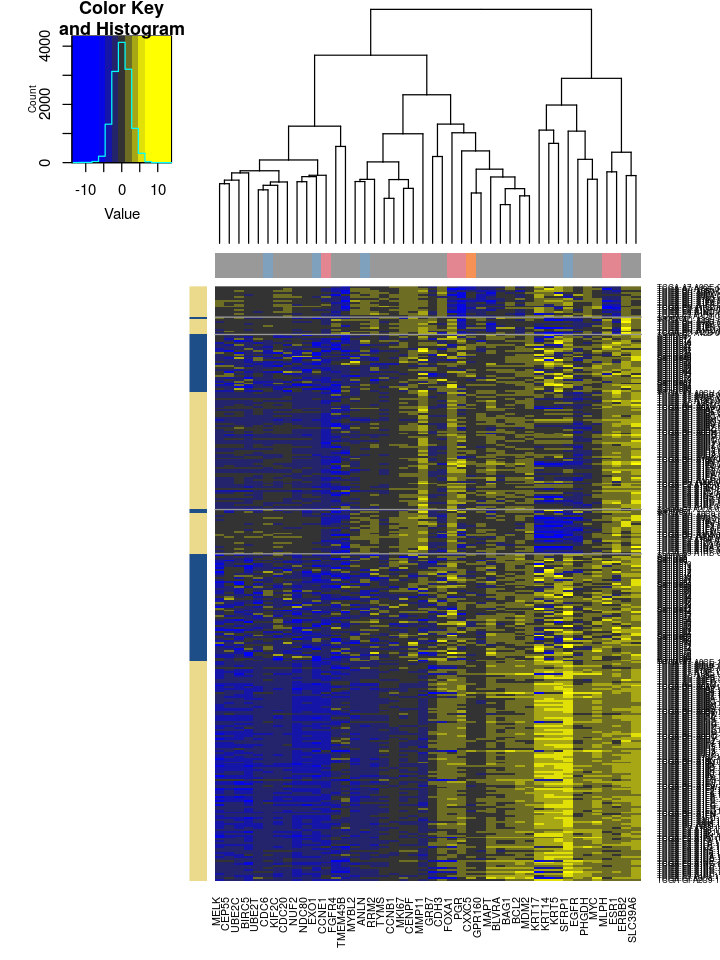

In [25]:
## Heatmap with species color bar
heatmap.2(combat.edata[names(sort(preds[,1])),], trace='none', col=colorRampPalette(c('blue','blue','grey20','yellow','yellow')), RowSideColors=preds.cols[names(sort(preds[,1])),2], dendrogram='column', ColSideColors=genes.cols, Rowv='none', rowsep=rowsep.nums, sepcolor='grey60')
pdf(PAM50.combined.species.bar,width=8,height=20)
heatmap.2(combat.edata[names(sort(preds[,1])),], trace='none', col=colorRampPalette(c('blue','blue','grey20','yellow','yellow')), RowSideColors=preds.cols[names(sort(preds[,1])),2], dendrogram='column', ColSideColors=genes.cols, Rowv='none', rowsep=rowsep.nums, sepcolor='grey60')
dev.off()

Unless the default paths have been changed above the
image files generated by this notebook may be downloaded using the
Jupyter directory browser interface at
[`./user_data/output`](./user_data/output).